https://www.kaggle.com/competitions/oxford-102-flower-pytorch

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import random
from skimage.io import imread
from sklearn.utils import class_weight
from collections import Counter
import time

In [2]:
# PyTorch libraries and modules
import torch
import torch.utils.data as data_utils
import torch.nn.functional as F
# pip3 install torch_optimizer
import torch_optimizer as optim
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d 
from torch.nn import Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, lr_scheduler

from torchvision import datasets, transforms, models

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import Utils (models, ...)
sys.path.append("Utils/")
from RunModel_Pytorch import RunModel
from CustomModel_Pytorch import NeuralNet

In [5]:
# path dataset
path_train='flower_data/train/'
path_val='flower_data/valid/'
path_test='flower_data/test/'

In [6]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
num_category=[]
for x in os.listdir(path_train):
    num_category.append(x)
num_category[0:5]

['27', '48', '69', '1', '10']

In [8]:
len(set(num_category))

102

In [9]:
# Opening JSON file
f = open('flower_data/cat_to_name.json')
# json to dictionary
data_class = json.load(f)
# Closing file
f.close()

In [10]:
# dictionary classes
data_class['21']

'fire lily'

In [11]:
# make dataframe
train_folder_df=pd.DataFrame([data_class]).T
train_folder_df.columns=['class']

In [12]:
train_folder_df.head(3)

,class
21,fire lily
3,canterbury bells
45,bolero deep blue


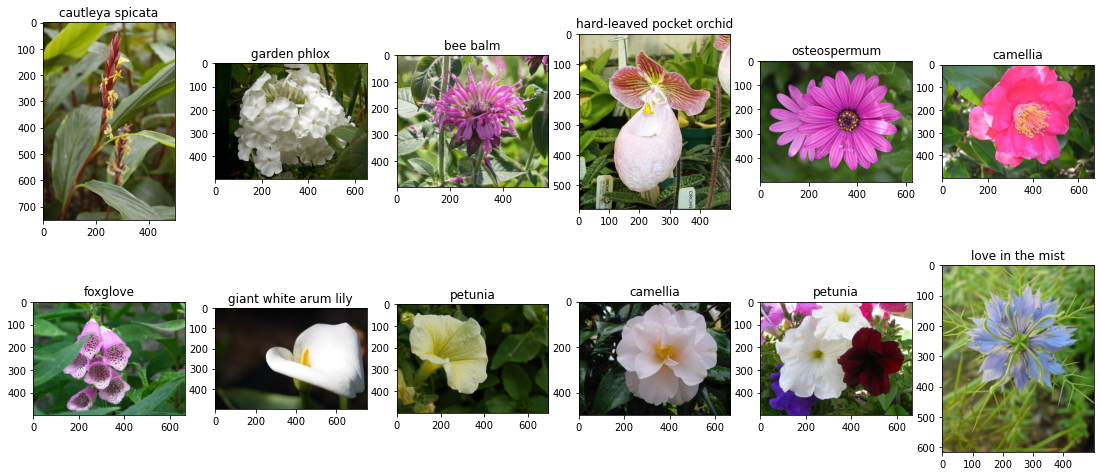

In [13]:
# plot some image examples
plt.figure(figsize = (19, 8))
i=1
for cl in range(12):
    im=train_folder_df.sample(n=1)
    ax=plt.subplot(2,6,i)
    path=path_train+im.index[0]+'/'
    #img = cv2.imread(path+random.choice(os.listdir(path)))
    img = imread(path+random.choice(os.listdir(path)))
    plt.imshow(img)
    plt.title(im['class'][0])
    i+=1
    

In [14]:
# counter (checking balance data classes)
counter={}
for i, row in train_folder_df.iterrows():
    count_={row[0]:len(os.listdir(path_train+i[0]))}
    counter.update(count_)
    
counter_df=pd.DataFrame([counter]).T.reset_index()  
counter_df.columns=['class','count']
counter_df['class_num']=train_folder_df.index
counter_df.head(3)

,class,count,class_num
0,fire lily,49,21
1,canterbury bells,36,3
2,bolero deep blue,44,45


In [15]:
# min max database flower class
counter_df.describe().T[['min', 'max']]

,min,max
count,27.0,70.0


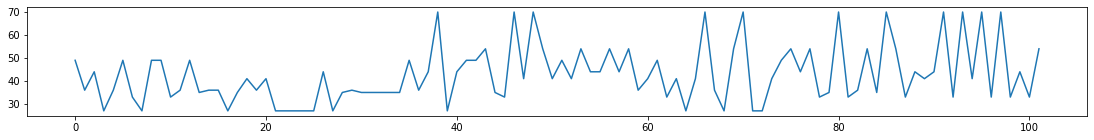

In [16]:
plt.figure(figsize = (19, 2))
plt.plot(counter_df.index, counter_df['count']);

## Convolutional Neural Network (CNN) PyTorch

In [17]:
# target_size
target_size = 64
# number of subprocesses data loading
num_workers = 4
# samples per batch to load
batch_size = 64
# percentage of training set to use as validation
#valid_size = 0.2

In [18]:
# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize(np.int(target_size*1.2)),
    transforms.RandomResizedCrop(target_size),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(np.int(target_size*1.2)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

In [19]:
# load and transform data using ImageFolder
train_data = datasets.ImageFolder(path_train, transform=train_transform)
val_data = datasets.ImageFolder(path_val, transform=test_transform)
test_data = datasets.ImageFolder(path_test, transform=test_transform)

In [20]:
train_data

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: flower_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=76, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [21]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

In [22]:
all_values_class=[]
for i, row in counter_df.iterrows():
    for j in range(row[1]):
        all_values_class.append(row[2])
len(all_values_class)

4360

In [23]:
# class_weight - Unbalanced Data                       
class_weights = class_weight.compute_class_weight('balanced', np.unique(all_values_class),all_values_class)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights=None

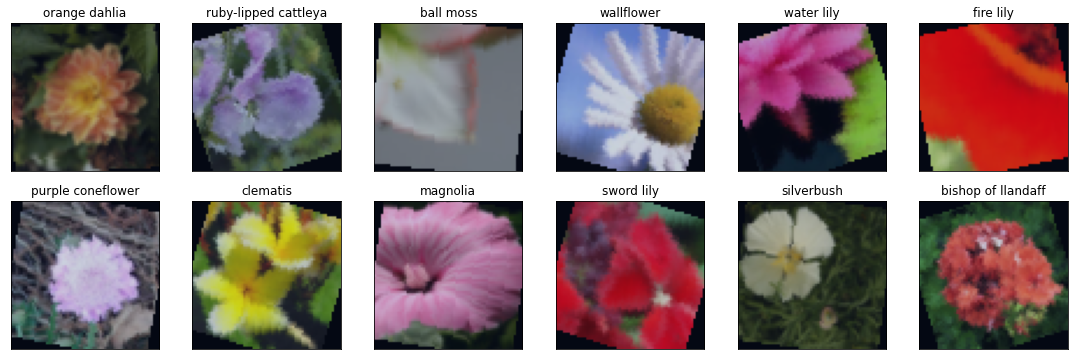

In [24]:
# visualize a batch of train data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
for i in np.arange(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title(data_class[str(labels[i].numpy())])

In [25]:
# plot output function
def plot_model_output(history, name='model'):
    
    loss_values = history['train_loss']
    val_loss_values = history['val_loss']
    accuracy_values = history['train_acc']
    val_accuracy_values = history['val_acc']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Custom Model

In [26]:
# PyTorch CNN architecture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
        
model = NeuralNet(len(set(num_category)))
model.to(device)
model

cpu


NeuralNet(
  (cnn_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14

### Pre-trained Resnet50

In [27]:
# Load the pretrained model from pytorch
model_resnet50 = models.resnet50(pretrained=True)

In [28]:
# print out the model structure
print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
print(model_resnet50.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [30]:
# Freeze training for all "features" layers
for name, param in model_resnet50.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [31]:
# Final Classifier Layer
model_resnet50.fc = Sequential(Linear(model_resnet50.fc.in_features,1000),
                                  ReLU(),
                                  Dropout(0.5),
                                  Linear(1000, len(set(num_category))))
print(model_resnet50.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=102, bias=True)
)


In [32]:
for param in model_resnet50.fc.parameters():
    param.require_grad = True

### Run Models

In [33]:
criterion = CrossEntropyLoss()
optimizer_ = optim.RAdam(model_resnet50.parameters(), lr=0.001)
optimizer = optim.Lookahead(optimizer_)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=4, threshold=0.00001, threshold_mode='abs', verbose=True)
model_save='Models/modelo_resnet50.pth'
# RunModel
history = RunModel(model_resnet50, train_loader, valid_loader, criterion, optimizer,
                   scheduler, model_save, n_epochs=30).train_model()

cpu


Epoch: 1, Training_Loss: 4.4839, Validation_Loss: 4.1442, Training_accuracy = 0.0475, Validation_accuracy = 0.1308, lr = 0.001
Validation loss decreased (inf --> 4.144173).  Saving model ...


Epoch: 2, Training_Loss: 3.8820, Validation_Loss: 3.0504, Training_accuracy = 0.1696, Validation_accuracy = 0.3594, lr = 0.001
Validation loss decreased (4.144173 --> 3.050376).  Saving model ...


Epoch: 3, Training_Loss: 2.9756, Validation_Loss: 2.0840, Training_accuracy = 0.3167, Validation_accuracy = 0.5024, lr = 0.001
Validation loss decreased (3.050376 --> 2.084012).  Saving model ...


Epoch: 4, Training_Loss: 2.3613, Validation_Loss: 1.5709, Training_accuracy = 0.4226, Validation_accuracy = 0.6137, lr = 0.001
Validation loss decreased (2.084012 --> 1.570896).  Saving model ...


Epoch: 5, Training_Loss: 2.0350, Validation_Loss: 1.2736, Training_accuracy = 0.4795, Validation_accuracy = 0.6724, lr = 0.001
Validation loss decreased (1.570896 --> 1.273553).  Saving model ...


Epoch: 6, Training_Loss: 1.8069, Validation_Loss: 1.1207, Training_accuracy = 0.5256, Validation_accuracy = 0.7164, lr = 0.001
Validation loss decreased (1.273553 --> 1.120710).  Saving model ...


Epoch: 7, Training_Loss: 1.6099, Validation_Loss: 1.0473, Training_accuracy = 0.5754, Validation_accuracy = 0.7164, lr = 0.001
Validation loss decreased (1.120710 --> 1.047306).  Saving model ...


Epoch: 8, Training_Loss: 1.5138, Validation_Loss: 0.9580, Training_accuracy = 0.5949, Validation_accuracy = 0.7592, lr = 0.001
Validation loss decreased (1.047306 --> 0.958038).  Saving model ...


Epoch: 9, Training_Loss: 1.4127, Validation_Loss: 0.8735, Training_accuracy = 0.6216, Validation_accuracy = 0.7592, lr = 0.001
Validation loss decreased (0.958038 --> 0.873508).  Saving model ...


Epoch: 10, Training_Loss: 1.3469, Validation_Loss: 0.8528, Training_accuracy = 0.6320, Validation_accuracy = 0.7653, lr = 0.001
Validation loss decreased (0.873508 --> 0.852786).  Saving model ...


Epoch: 11, Training_Loss: 1.2756, Validation_Loss: 0.7582, Training_accuracy = 0.6571, Validation_accuracy = 0.7848, lr = 0.001
Validation loss decreased (0.852786 --> 0.758159).  Saving model ...


Epoch: 12, Training_Loss: 1.2003, Validation_Loss: 0.6956, Training_accuracy = 0.6679, Validation_accuracy = 0.8117, lr = 0.001
Validation loss decreased (0.758159 --> 0.695639).  Saving model ...


Epoch: 13, Training_Loss: 1.1489, Validation_Loss: 0.6847, Training_accuracy = 0.6801, Validation_accuracy = 0.8093, lr = 0.001
Validation loss decreased (0.695639 --> 0.684720).  Saving model ...


Epoch: 14, Training_Loss: 1.1364, Validation_Loss: 0.6188, Training_accuracy = 0.6832, Validation_accuracy = 0.8386, lr = 0.001
Validation loss decreased (0.684720 --> 0.618800).  Saving model ...


Epoch: 15, Training_Loss: 1.0799, Validation_Loss: 0.6834, Training_accuracy = 0.7013, Validation_accuracy = 0.8117, lr = 0.001


Epoch: 16, Training_Loss: 1.0526, Validation_Loss: 0.6016, Training_accuracy = 0.7085, Validation_accuracy = 0.8337, lr = 0.001
Validation loss decreased (0.618800 --> 0.601557).  Saving model ...


Epoch: 17, Training_Loss: 1.0031, Validation_Loss: 0.5811, Training_accuracy = 0.7241, Validation_accuracy = 0.8337, lr = 0.001
Validation loss decreased (0.601557 --> 0.581122).  Saving model ...


Epoch: 18, Training_Loss: 0.9992, Validation_Loss: 0.5616, Training_accuracy = 0.7170, Validation_accuracy = 0.8362, lr = 0.001
Validation loss decreased (0.581122 --> 0.561604).  Saving model ...


Epoch: 19, Training_Loss: 0.9328, Validation_Loss: 0.5643, Training_accuracy = 0.7367, Validation_accuracy = 0.8423, lr = 0.001


Epoch: 20, Training_Loss: 0.9384, Validation_Loss: 0.5580, Training_accuracy = 0.7382, Validation_accuracy = 0.8240, lr = 0.001
Validation loss decreased (0.561604 --> 0.557997).  Saving model ...


Epoch: 21, Training_Loss: 0.9078, Validation_Loss: 0.5269, Training_accuracy = 0.7466, Validation_accuracy = 0.8496, lr = 0.001
Validation loss decreased (0.557997 --> 0.526851).  Saving model ...


Epoch: 22, Training_Loss: 0.9149, Validation_Loss: 0.5001, Training_accuracy = 0.7479, Validation_accuracy = 0.8533, lr = 0.001
Validation loss decreased (0.526851 --> 0.500147).  Saving model ...


Epoch: 23, Training_Loss: 0.8463, Validation_Loss: 0.4964, Training_accuracy = 0.7585, Validation_accuracy = 0.8545, lr = 0.001
Validation loss decreased (0.500147 --> 0.496365).  Saving model ...


Epoch: 24, Training_Loss: 0.8431, Validation_Loss: 0.5199, Training_accuracy = 0.7599, Validation_accuracy = 0.8619, lr = 0.001


Epoch: 25, Training_Loss: 0.8215, Validation_Loss: 0.5701, Training_accuracy = 0.7618, Validation_accuracy = 0.8386, lr = 0.001


Epoch: 26, Training_Loss: 0.8302, Validation_Loss: 0.5013, Training_accuracy = 0.7685, Validation_accuracy = 0.8606, lr = 0.001


Epoch: 27, Training_Loss: 0.7945, Validation_Loss: 0.5433, Training_accuracy = 0.7755, Validation_accuracy = 0.8337, lr = 0.001


Epoch: 28, Training_Loss: 0.7757, Validation_Loss: 0.4871, Training_accuracy = 0.7807, Validation_accuracy = 0.8655, lr = 0.001
Validation loss decreased (0.496365 --> 0.487075).  Saving model ...


Epoch: 29, Training_Loss: 0.7972, Validation_Loss: 0.5043, Training_accuracy = 0.7761, Validation_accuracy = 0.8582, lr = 0.001


Epoch: 30, Training_Loss: 0.7855, Validation_Loss: 0.5172, Training_accuracy = 0.7766, Validation_accuracy = 0.8545, lr = 0.001


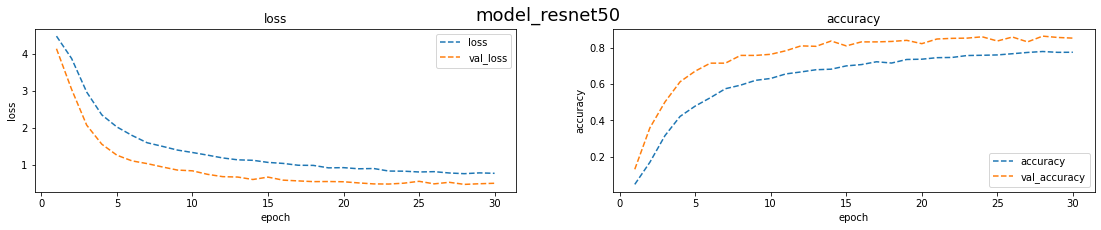

In [34]:
# plot model ouputs
plot_model_output(history, 'model_resnet50')

In [35]:
def valid_model2(model):
    sum_correct = 0
    sum_total = 0
    # torch.no_grad
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], labels).view(-1)
            sum_correct += torch.sum(correct).item()
            sum_total += correct.shape[0]  
    print('correct: {:d}  total: {:d}'.format(sum_correct, sum_total))
    print('accuracy = {:f}'.format(sum_correct / sum_total))
    #return F.softmax(outputs, dim=1)

In [36]:
valid_model2(model_resnet50)

correct: 699  total: 818
accuracy = 0.854523
